# Degradation Modelling 

This rover shows how degradation modelling can be performed to model the resilience of an engineered system over its entire lifecycle.

In [1]:
import sys, os
sys.path.insert(0,os.path.join('..','..'))

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as stats


import multiprocessing as mp

In [2]:
from rover_model_human import *
from rover_model import plot_trajectories, plot_map

In [3]:
"""
import importlib
import rover_model_human
importlib.reload(rover_model_human)
importlib.reload(rd.plot)
from rover_model_human import *
import fmdtools.resultdisp as rd
"""

'\nimport importlib\nimport rover_model_human\nimportlib.reload(rover_model_human)\nimportlib.reload(rd.plot)\nfrom rover_model_human import *\nimport fmdtools.resultdisp as rd\n'

Degradation models are defined independently of the fault model, but have attributes (e.g., functions) which may correspond to it directly.

Because degradation may only occur in specific functions/flows (and may not have inter-functional dependencies), it is not necessary for the degradation model to have the same 

In [4]:
deg_mdl = RoverDegradation()

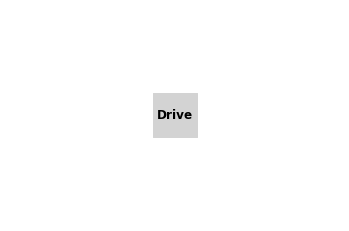

In [5]:
figax = rd.graph.show(deg_mdl, gtype='normal')

In [6]:
deg_mdl_hum_long = HumanDegradationLong()

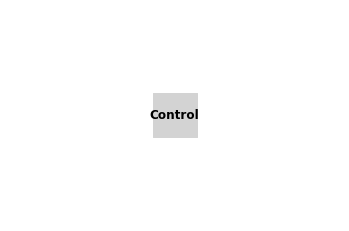

In [7]:
figax = rd.graph.show(deg_mdl_hum_long, gtype='normal')

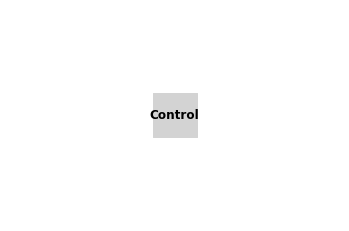

In [8]:
deg_mdl_hum_short = HumanDegradationShort()
figax = rd.graph.show(deg_mdl_hum_short, gtype='normal')

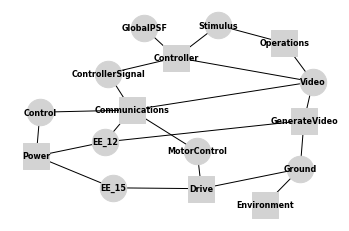

In [9]:
fault_mdl = Rover()
fig, ax = rd.graph.show(fault_mdl, gtype='bipartite')

In [10]:
fig.savefig("func_model.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

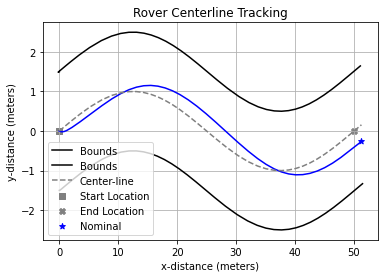

In [11]:
mdl = Rover(params=gen_params('sine', amplitude=1))
endresults, resgraph, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)
fig = plt.gcf()

In [12]:
fig.savefig("sine_rover_environment.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, there are two degradation models here:
- one which focusses solely on faults in the drive system, and
- one which focusses on the human degradation of fatigue
Below we simulate these to model to the degradation behaviors being modelled in this drive system.

# Drive Degradation

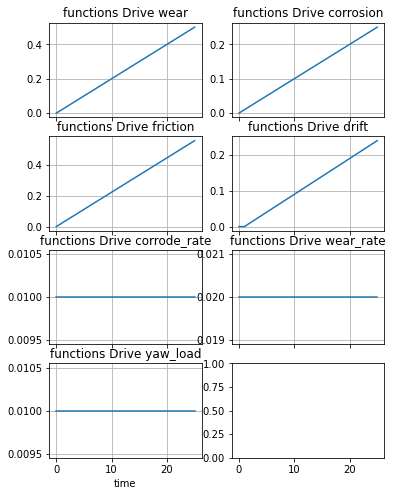

In [13]:
deg_mdl = RoverDegradation()
endresults, resgraph, mdlhist = prop.nominal(deg_mdl)
fig = rd.plot.mdlhists(mdlhist)

The major behaviors are:
- wear
- corrosion
- friction
- drift

These behaviors result from the accumulation of the following rates over each time-step:
- yaw_load 
- corrode_rate
- wear_rate

These degradation behaviors have additionally been defined to simulate stochastically if desired:

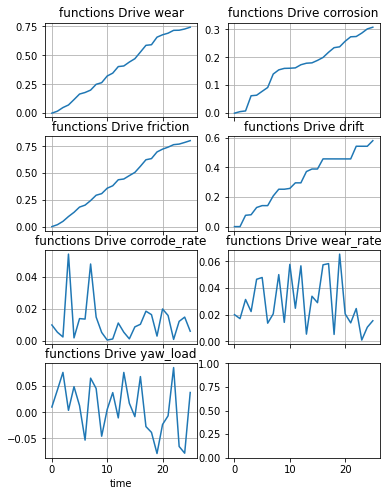

In [14]:
deg_mdl = RoverDegradation()
endresults_deg, resgraph_deg, mdlhist_deg = prop.nominal(deg_mdl, run_stochastic=True)
fig = rd.plot.mdlhists(mdlhist_deg)

To get averages/percentages over a number of scenarios, we can view these behaviors over a given number of random seeds:

In [15]:
nomapp_deg = NominalApproach()
nomapp_deg.add_seed_replicates('test', 100)
endclasses_deg, mdlhists_deg = prop.nominal_approach(deg_mdl, nomapp_deg, run_stochastic=True)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 636.04it/s]


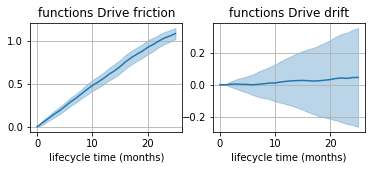

In [16]:
fig, ax = rd.plot.mdlhists(mdlhists_deg, aggregation='mean_std', fxnflowvals={'Drive':['friction','drift']}, title="", xlabel='lifecycle time (months)')

In [17]:
fig.savefig("drive_degradations.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while wear and friction proceed monotonically, drift can go one way or another, meaning that whether the rover drifts left or right is basically up to chance. We can further look at slices of these distributions:

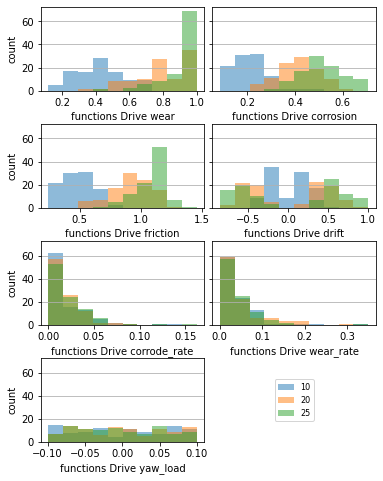

In [18]:
fig, axs = rd.plot.metric_dist_from(mdlhists_deg, [10, 20, 25], fxnflowvals='Drive', bins=10, alpha=0.5)

Given the parameter information (friction and drift) that the degradation model produced, we can now simulate the model with this information over time in the nominal scenarios.

In [19]:
behave_nomapp = NominalApproach()
behave_nomapp.add_param_ranges(gen_sample_params_comp, 'behave_nomapp', mdlhists_deg, t=(1,26,4), scen = (1,30,1), turn='sine')

In [23]:
mdl=Rover()
behave_endclasses, behave_mdlhists = prop.nominal_approach(mdl, behave_nomapp)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 203/203 [00:06<00:00, 29.67it/s]


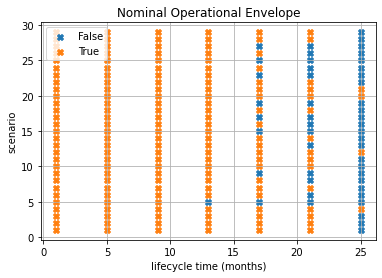

In [24]:
fig = rd.plot.nominal_vals_2d(behave_nomapp, behave_endclasses, 't', 'scen', xlabel='lifecycle time (months)', ylabel='scenario', legendloc='upper left', metric='at_finish')

In [25]:
fig.savefig("drive_deg_envelope.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

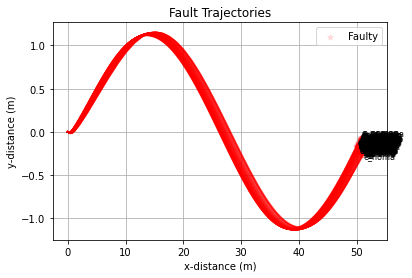

In [26]:
fig = plot_trajectories(behave_mdlhists)

As shown, as the time (and thus degradation) increases, the rover becomes more likely to be unable to complete the mission. In this case, it results in the rover not completing the mission in time.

In [29]:
behave_endclasses_nested, behave_mdlhists_nested, behave_apps_nested = prop.nested_approach(mdl, behave_nomapp, pool=mp.Pool(5), faults='Drive', track='flows')


NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 203/203 [01:32<00:00,  2.19it/s]


Finally, we can also visualize simulate and then view the effect of the degradation on average resilience...

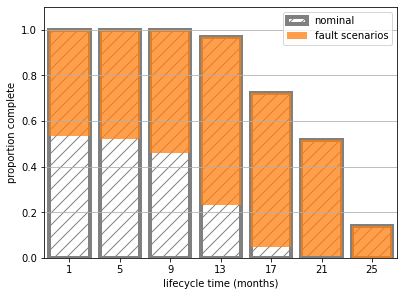

In [30]:
res_comp = rd.tabulate.resilience_factor_comparison(behave_nomapp, behave_endclasses_nested, ['t'], 'at_finish', percent=False)
fig = rd.plot.resilience_factor_comparison(res_comp, stack=True, maxy=1.1, xlabel='lifecycle time (months)', figsize=(5.5,4), title="", stat="proportion complete")   

In [31]:
fig.savefig("drive_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while there is some resilience early in the lifecycle (resulting in a small proportion of faults being recovered), this resilience goes away with degradation.

In [32]:
res_comp

('t',)   nominal     Drive
1       1.000000 -0.464240
5       1.000000 -0.477650
9       1.000000 -0.541507
13      0.965517 -0.733716
17      0.724138 -0.674968
21      0.517241 -0.510856
25      0.137931 -0.137292

# Human Degradation

We can also perform this assessment for the human error model, which is split up into two parts:
- long term "degradation" of experience over months
- short term "degradation" of stress and fatigue over a day

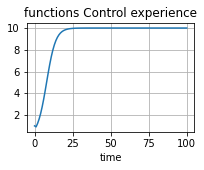

In [33]:
deg_mdl_hum_long = HumanDegradationLong()
endresults, resgraph, mdlhist_hum_long = prop.nominal(deg_mdl_hum_long)
fig,ax = rd.plot.mdlhists(mdlhist_hum_long)

In [34]:
nomapp_hum_long = NominalApproach()
experience_param = np.random.default_rng(seed=101).gamma(1,1.9,101)
experience_param = list(experience_param)
nomapp_hum_long.add_param_ranges(gen_long_degPSF_param, 'nomapp_hum_long', experience_param, scen = (0,25,1))

In [35]:
endclasses, mdlhists_hum_long = prop.nominal_approach(deg_mdl_hum_long, nomapp_hum_long, run_stochastic=True)

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 375.77it/s]


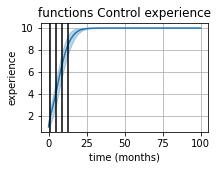

In [36]:
fig,ax = rd.plot.mdlhists(mdlhists_hum_long, aggregation='mean_std', time_slice = [1,5,9,13], legend_loc=-1, xlabel="time (months)", ylabels={("functions", "Control", "experience"):"experience"})

In [37]:
fig.savefig("experience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Short-term degradation

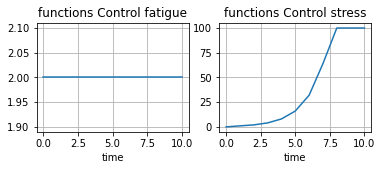

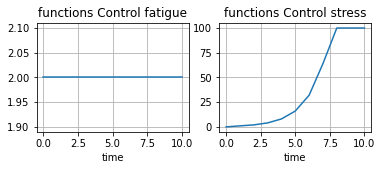

In [38]:
deg_mdl_hum_short = HumanDegradationShort()
endresults, resgraph, mdlhist_hum_short = prop.nominal(deg_mdl_hum_short)
fig, axs = rd.plot.mdlhists(mdlhist_hum_short)
endresults, resgraph, mdlhist_hum_short = prop.nominal(deg_mdl_hum_short, run_stochastic=True)
fig, axs = rd.plot.mdlhists(mdlhist_hum_short)

In [39]:
mdlhist_hum_short

{'flows': {},
 'functions': {'Control': {'fatigue': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
   'stress': array([  0,   1,   2,   4,   8,  16,  32,  64, 100, 100, 100])}},
 'time': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

short-term degradation (over no external params)

In [40]:
nomapp_human_short = NominalApproach()
nomapp_human_short.add_seed_replicates('test', 25)

In [41]:
endclasses_human_short, mdlhists_human_short = prop.nominal_approach(deg_mdl_hum_short, nomapp_human_short, run_stochastic=True)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1395.11it/s]


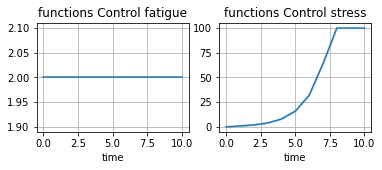

In [42]:
fig, ax = rd.plot.mdlhists(mdlhists_human_short, aggregation='mean_std')

short-term degradation over long-term params

In [43]:
stress_param = np.random.default_rng(seed=101).gamma(2,1.9,101)
stress_param = list(stress_param)

In [44]:
nomapp_short_long = NominalApproach()
nomapp_short_long.add_param_ranges(gen_short_degPSF_param, 'nomapp', mdlhists_hum_long, stress_param, scen = (0,25,1), t= (1,15,4))
nomapp_short_long.update_factor_seeds('nomapp', 'scen')

In [45]:
endclasses, mdlhists_hum_short_long = prop.nominal_approach(deg_mdl_hum_short, nomapp_short_long, run_stochastic=True)    

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1742.73it/s]


In [46]:
nomapp_short_long.ranges['nomapp']['inputranges']

{'scen': (0, 25, 1), 't': (1, 15, 4)}

In [47]:
comp_groups = nomapp_short_long.get_param_scens('nomapp', 't')

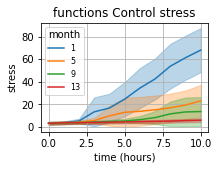

In [48]:
fig, ax = rd.plot.mdlhists(mdlhists_hum_short_long, fxnflowvals={"Control":"stress"}, comp_groups=comp_groups, aggregation='mean_std',
                           xlabel="time (hours)", cols=1,ylabels={("functions", "Control", "stress"):"stress"}, legend_title='month')

In [49]:
fig.savefig("stress_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [50]:
behave_nomapp_hum = NominalApproach()
behave_nomapp_hum.add_param_ranges(gen_human_params_combined, 'behave_nomapp_hum', mdlhists_hum_short_long, nomapp_short_long, 'nomapp', t_stress=(1,11, 2), t_exp=(1,15,4), scen = (1,25, 1), turn='sine')

In [51]:
mdl=Rover()
behave_endclasses_hum, behave_mdlhists_hum = prop.nominal_approach(mdl, behave_nomapp_hum, run_stochastic=True)   

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 480/480 [00:15<00:00, 31.04it/s]


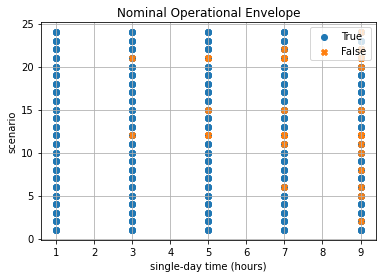

In [52]:
fig = rd.plot.nominal_vals_2d(behave_nomapp_hum, behave_endclasses_hum, 't_stress', 'scen', xlabel='single-day time (hours)', ylabel='scenario',  metric='at_finish', nomlabel='True')

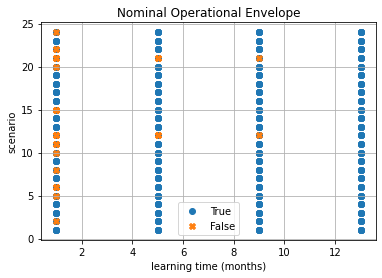

In [53]:
fig = rd.plot.nominal_vals_2d(behave_nomapp_hum, behave_endclasses_hum, 't_exp', 'scen', xlabel='learning time (months)', ylabel='scenario',  metric='at_finish', nomlabel='True')

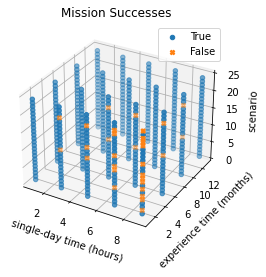

In [54]:
fig = rd.plot.nominal_vals_3d(behave_nomapp_hum, behave_endclasses_hum, 't_stress', 't_exp', 'scen', xlabel='single-day time (hours)', ylabel = 'experience time (months)', zlabel='scenario',  metric='at_finish', nomlabel='True', title="Mission Successes")

In [55]:
fig.savefig("human_nominal_joint_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

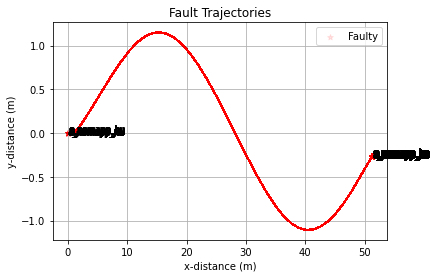

In [56]:
fig = plot_trajectories(behave_mdlhists_hum)

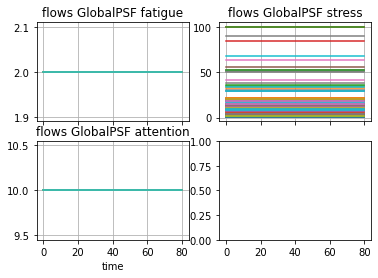

In [57]:
fig, ax = rd.plot.mdlhists(behave_mdlhists_hum, fxnflowvals='GlobalPSF',   legend_loc=False)

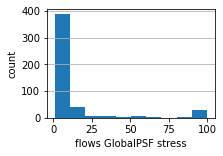

In [58]:
fig, ax = rd.plot.metric_dist_from(behave_mdlhists_hum, 1, fxnflowvals={'GlobalPSF':'stress'})

In [59]:
nom_comp_hum = rd.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_exp','t_stress'], ['at_finish'], give_ci=True, return_anyway=True, percent=True)
nom_comp_hum

metric    (1, 1)              (1, 3)                     (1, 5)            \
                   LB   UB                  LB        UB               LB   
at_finish    1.0  1.0  1.0  0.916667  0.666667  0.958333  0.875  0.622095   

metric              (1, 7)  ... (13, 3) (13, 5)           (13, 7)            \
                 UB         ...      UB           LB   UB           LB   UB   
at_finish  0.958333   0.75  ...     1.0     1.0  1.0  1.0     1.0  1.0  1.0   

metric    (13, 9)            
                    LB   UB  
at_finish     1.0  1.0  1.0  

[1 rows x 60 columns]

In [60]:
scendict = behave_nomapp_hum.get_param_scens('behave_nomapp_hum', 't_exp','t_stress')
late_scens = scendict[13,5]
early_scens= scendict[13,1]

In [61]:
late_scens

{'behave_nomapp_hum_265',
 'behave_nomapp_hum_266',
 'behave_nomapp_hum_267',
 'behave_nomapp_hum_268',
 'behave_nomapp_hum_269',
 'behave_nomapp_hum_270',
 'behave_nomapp_hum_271',
 'behave_nomapp_hum_272',
 'behave_nomapp_hum_273',
 'behave_nomapp_hum_274',
 'behave_nomapp_hum_275',
 'behave_nomapp_hum_276',
 'behave_nomapp_hum_277',
 'behave_nomapp_hum_278',
 'behave_nomapp_hum_279',
 'behave_nomapp_hum_280',
 'behave_nomapp_hum_281',
 'behave_nomapp_hum_282',
 'behave_nomapp_hum_283',
 'behave_nomapp_hum_284',
 'behave_nomapp_hum_285',
 'behave_nomapp_hum_286',
 'behave_nomapp_hum_287',
 'behave_nomapp_hum_288'}

In [62]:
early_scens

{'behave_nomapp_hum_73',
 'behave_nomapp_hum_74',
 'behave_nomapp_hum_75',
 'behave_nomapp_hum_76',
 'behave_nomapp_hum_77',
 'behave_nomapp_hum_78',
 'behave_nomapp_hum_79',
 'behave_nomapp_hum_80',
 'behave_nomapp_hum_81',
 'behave_nomapp_hum_82',
 'behave_nomapp_hum_83',
 'behave_nomapp_hum_84',
 'behave_nomapp_hum_85',
 'behave_nomapp_hum_86',
 'behave_nomapp_hum_87',
 'behave_nomapp_hum_88',
 'behave_nomapp_hum_89',
 'behave_nomapp_hum_90',
 'behave_nomapp_hum_91',
 'behave_nomapp_hum_92',
 'behave_nomapp_hum_93',
 'behave_nomapp_hum_94',
 'behave_nomapp_hum_95',
 'behave_nomapp_hum_96'}

In [63]:
behave_nomapp_hum.scenarios['behave_nomapp_hum_90']['properties']['params']

{'linetype': 'sine',
 'amp': 1.0,
 'period': 0.12566370614359174,
 'initangle': 7.200000000000001,
 'end': [50, 0],
 'degradation': {'friction': 0.0, 'drift': 0.0},
 'fatigue': 2.0,
 'stress': 4.0,
 'attention': 10}

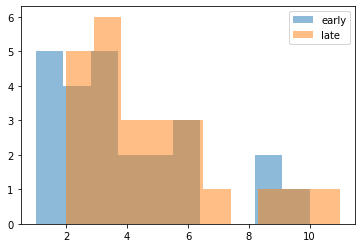

In [64]:
plt.hist([behave_nomapp_hum.scenarios[scen]['properties']['params']['stress'] for scen in early_scens], alpha=0.5, label='early')
plt.hist([behave_nomapp_hum.scenarios[scen]['properties']['params']['stress'] for scen in late_scens], alpha=0.5, label='late')
plt.legend()

In [65]:
behave_endclasses_hum

{'behave_nomapp_hum_1': {'rate': 0,
  'cost': 0,
  'prob': 0.0020833333333333333,
  'expected cost': 0,
  'at_finish': True,
  'line_dist': 0.42173833732495913,
  'num_modes': 0,
  'end_dist': 1.2846781994919658,
  'faults': {},
  'classification': 'nominal mission',
  'x': 51.25717281508949,
  'y': -0.2644136706940217},
 'behave_nomapp_hum_2': {'rate': 0,
  'cost': 0,
  'prob': 0.0020833333333333333,
  'expected cost': 0,
  'at_finish': True,
  'line_dist': 0.42173833732495913,
  'num_modes': 0,
  'end_dist': 1.2846781994919658,
  'faults': {},
  'classification': 'nominal mission',
  'x': 51.25717281508949,
  'y': -0.2644136706940217},
 'behave_nomapp_hum_3': {'rate': 0,
  'cost': 0,
  'prob': 0.0020833333333333333,
  'expected cost': 0,
  'at_finish': True,
  'line_dist': 0.42173833732495913,
  'num_modes': 0,
  'end_dist': 1.2846781994919658,
  'faults': {},
  'classification': 'nominal mission',
  'x': 51.25717281508949,
  'y': -0.2644136706940217},
 'behave_nomapp_hum_4': {'rate'

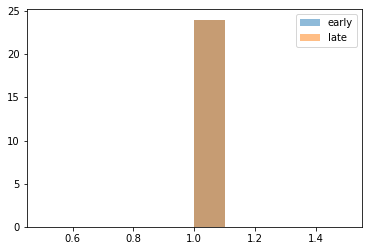

In [66]:
plt.hist([int(behave_endclasses_hum[scen]['at_finish']) for scen in early_scens], alpha=0.5, label='early')
plt.hist([float(behave_endclasses_hum[scen]['at_finish']) for scen in late_scens], alpha=0.5, label='late')
plt.legend()

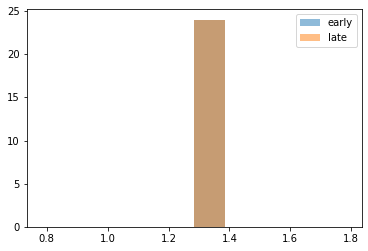

In [67]:
plt.hist([behave_endclasses_hum[scen]['end_dist'] for scen in early_scens], alpha=0.5, label='early')
plt.hist([behave_endclasses_hum[scen]['end_dist'] for scen in late_scens], alpha=0.5, label='late')
plt.legend()

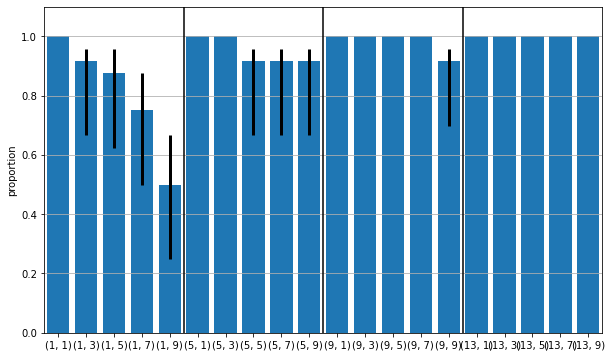

In [68]:
fig = rd.plot.nominal_factor_comparison(nom_comp_hum, 'at_finish', maxy=1.1, xlabel='single-day time (hours)', figsize=(10,6), title="", error_bars=True)  

In [69]:
nom_comp_hum = rd.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_exp'], ['at_finish'], percent=False)
nom_comp_hum

('t_exp',)        1     5         9    13
at_finish   0.808333  0.95  0.983333  1.0

In [70]:
nom_comp_hum = rd.tabulate.nominal_factor_comparison(behave_nomapp_hum, behave_endclasses_hum, ['t_stress'], ['at_finish'],  percent=False)
nom_comp_hum

('t_stress',)    1         3         5         7         9
at_finish      1.0  0.979167  0.947917  0.916667  0.833333

As for the human resilience:

In [72]:
behave_endclasses_nested_hum, behave_mdlhists_nested_hum, behave_apps_nested_hum = prop.nested_approach(mdl, behave_nomapp_hum, pool=mp.Pool(5), faults='Drive', track='flows')

NESTED SCENARIOS COMPLETE:  22%|███████████▊                                         | 107/480 [00:48<02:41,  2.31it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  24%|████████████▊                                        | 116/480 [00:52<02:44,  2.21it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  42%|██████████████████████▍                              | 203/480 [01:30<01:57,  2.36it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  43%|██████████████████████▋                              | 206/480 [01:31<01:58,  2.31it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  44%|███████████████████████▍                             | 212/480 [01:34<01:55,  2.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  47%|█████████████████████████                            | 227/480 [01:40<01:48,  2.34it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  49%|██████████████████████████                           | 236/480 [01:44<01:46,  2.29it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  61%|████████████████████████████████▎                    | 293/480 [02:09<01:20,  2.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  62%|████████████████████████████████▉                    | 298/480 [02:11<01:19,  2.30it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  62%|█████████████████████████████████                    | 299/480 [02:12<01:19,  2.28it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  63%|█████████████████████████████████▎                   | 302/480 [02:13<01:16,  2.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  64%|██████████████████████████████████                   | 308/480 [02:15<01:13,  2.35it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  64%|██████████████████████████████████                   | 309/480 [02:16<01:12,  2.35it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  67%|███████████████████████████████████▋                 | 323/480 [02:22<01:06,  2.37it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  69%|████████████████████████████████████▋                | 332/480 [02:26<01:03,  2.34it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  80%|██████████████████████████████████████████▌          | 385/480 [02:49<00:40,  2.33it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  81%|██████████████████████████████████████████▊          | 388/480 [02:50<00:39,  2.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  81%|██████████████████████████████████████████▉          | 389/480 [02:51<00:38,  2.35it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  81%|███████████████████████████████████████████▏         | 391/480 [02:51<00:37,  2.39it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  82%|███████████████████████████████████████████▍         | 393/480 [02:52<00:36,  2.38it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  82%|███████████████████████████████████████████▌         | 394/480 [02:53<00:35,  2.39it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  82%|███████████████████████████████████████████▌         | 395/480 [02:53<00:35,  2.38it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  83%|███████████████████████████████████████████▉         | 398/480 [02:54<00:34,  2.38it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  84%|████████████████████████████████████████████▍        | 403/480 [02:57<00:33,  2.29it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  84%|████████████████████████████████████████████▌        | 404/480 [02:57<00:32,  2.31it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  84%|████████████████████████████████████████████▋        | 405/480 [02:57<00:32,  2.33it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  85%|████████████████████████████████████████████▉        | 407/480 [02:58<00:31,  2.29it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  87%|██████████████████████████████████████████████▎      | 419/480 [03:03<00:25,  2.37it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  89%|███████████████████████████████████████████████▎     | 428/480 [03:07<00:22,  2.34it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  92%|████████████████████████████████████████████████▉    | 443/480 [03:14<00:15,  2.35it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  94%|█████████████████████████████████████████████████▉   | 452/480 [03:18<00:12,  2.30it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 480/480 [03:30<00:00,  2.29it/s]


In [73]:
res_comp_hum = rd.tabulate.resilience_factor_comparison(behave_nomapp_hum, behave_endclasses_nested_hum, ['t_exp','t_stress'], 'at_finish')
res_comp_hum

('t_exp', 't_stress')   nominal     Drive
1  1                   1.000000 -0.462963
   3                   0.916667 -0.424383
   5                   0.875000 -0.405093
   7                   0.750000 -0.347222
   9                   0.500000 -0.231481
5  1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   0.916667 -0.424383
   7                   0.916667 -0.424383
   9                   0.916667 -0.424383
9  1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   1.000000 -0.462963
   7                   1.000000 -0.462963
   9                   0.916667 -0.424383
13 1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   1.000000 -0.462963
   7                   1.000000 -0.462963
   9                   1.000000 -0.462963

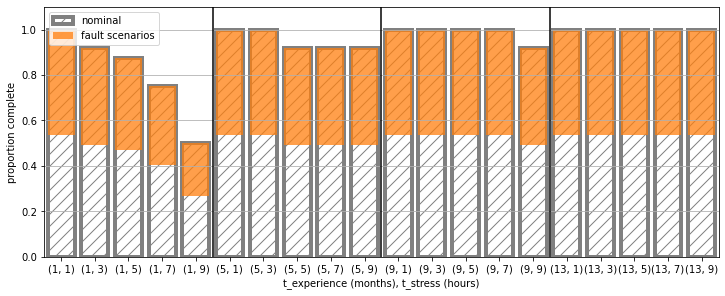

In [74]:
fig = rd.plot.resilience_factor_comparison(res_comp_hum, stack=True, maxy=1.1, xlabel='t_experience (months), t_stress (hours)', figsize=(10,4), title="", stat="proportion complete")  

In [75]:
fig.savefig("human_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [76]:
res_comp_hum

('t_exp', 't_stress')   nominal     Drive
1  1                   1.000000 -0.462963
   3                   0.916667 -0.424383
   5                   0.875000 -0.405093
   7                   0.750000 -0.347222
   9                   0.500000 -0.231481
5  1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   0.916667 -0.424383
   7                   0.916667 -0.424383
   9                   0.916667 -0.424383
9  1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   1.000000 -0.462963
   7                   1.000000 -0.462963
   9                   0.916667 -0.424383
13 1                   1.000000 -0.462963
   3                   1.000000 -0.462963
   5                   1.000000 -0.462963
   7                   1.000000 -0.462963
   9                   1.000000 -0.462963

# Combined Degradation

Idea: make same resilience plots as before but with degradation of resilience to drive faults at 0, 4, and 8 hours of fatigue.

Need method of doing this:
- take params for one and replace with the other (kind of hacky and requires independence)
- create composite of both? (how do you determine the merge between output params?)
- use a combined method with both histories as input and sample over t_life and t_day (use this one)

In [77]:
joint_nomapp = NominalApproach()
joint_nomapp.add_param_ranges(gen_sample_params_combined, 'behave_jointapp', mdlhists_deg, mdlhists_hum_short_long, nomapp_short_long, stress_id='nomapp',  t_comp=(1,26,12), t_stress=(1,11, 4), t_exp=(1,10,8), scen = (1,25,1), turn='sine')

In [78]:
mdl=Rover()
behave_endclasses_joint, behave_mdlhists_joint = prop.nominal_approach(mdl, joint_nomapp)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 432/432 [00:14<00:00, 29.01it/s]


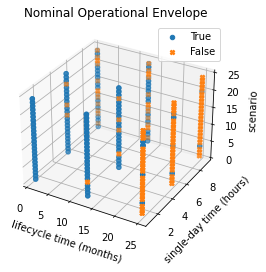

In [79]:
fig = rd.plot.nominal_vals_3d(joint_nomapp, behave_endclasses_joint, 't_comp', 't_stress', 'scen', xlabel='lifecycle time (months)', ylabel='single-day time (hours)', zlabel='scenario',  metric='at_finish', nomlabel='True')

In [80]:
nom_comp_hum = rd.tabulate.nominal_factor_comparison(joint_nomapp, behave_endclasses_joint, ['t_exp', 't_comp', 't_stress'], ['at_finish'], percent=False, return_anyway=True)
nom_comp_hum

1                                                           \
            1                     13                       25             
             1      5    9         1         5    9         1         5   
at_finish  1.0  0.875  0.5  0.958333  0.833333  0.5  0.166667  0.083333   

                       9                                                      \
                      1                        13                         25   
                  9    1    5         9         1         5      9         1   
at_finish  0.041667  1.0  1.0  0.916667  0.958333  0.958333  0.875  0.166667   

                               
                               
                  5         9  
at_finish  0.166667  0.083333

In [81]:
nom_comp_hum.columns

MultiIndex([(1,  1, 1),
            (1,  1, 5),
            (1,  1, 9),
            (1, 13, 1),
            (1, 13, 5),
            (1, 13, 9),
            (1, 25, 1),
            (1, 25, 5),
            (1, 25, 9),
            (9,  1, 1),
            (9,  1, 5),
            (9,  1, 9),
            (9, 13, 1),
            (9, 13, 5),
            (9, 13, 9),
            (9, 25, 1),
            (9, 25, 5),
            (9, 25, 9)],
           name=('t_exp', 't_comp', 't_stress'))

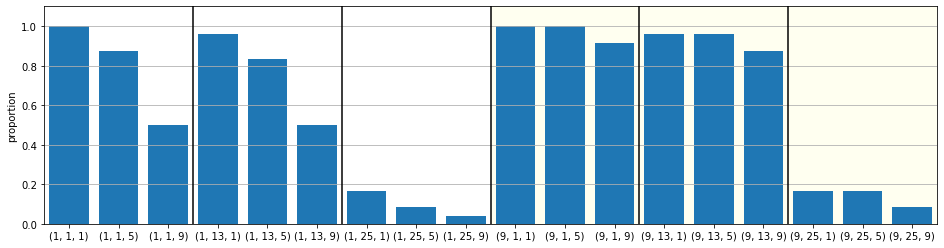

In [82]:
fig = rd.plot.nominal_factor_comparison(nom_comp_hum, 'at_finish', maxy=1.1, xlabel='single-day time (hours)', figsize=(16,4), title="", error_bars=True)  

Resilience assessment

In [85]:
behave_endclasses_nested_joint, behave_mdlhists_nested_hum, _ = prop.nested_approach(mdl, joint_nomapp, pool=mp.Pool(5), faults='Drive')

NESTED SCENARIOS COMPLETE:  14%|███████▍                                              | 59/432 [00:43<04:00,  1.55it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  14%|███████▊                                              | 62/432 [00:45<04:05,  1.50it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  16%|████████▌                                             | 68/432 [00:49<04:30,  1.34it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  22%|████████████▏                                         | 97/432 [01:10<04:02,  1.38it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  23%|████████████▎                                        | 100/432 [01:12<03:47,  1.46it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  23%|████████████▍                                        | 101/432 [01:13<03:44,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  24%|████████████▋                                        | 103/432 [01:14<03:45,  1.46it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  24%|████████████▉                                        | 105/432 [01:16<03:57,  1.38it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  25%|█████████████                                        | 106/432 [01:17<03:58,  1.37it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  25%|█████████████▏                                       | 107/432 [01:17<03:49,  1.41it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  25%|█████████████▍                                       | 110/432 [01:19<03:39,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  27%|██████████████                                       | 115/432 [01:23<03:35,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  27%|██████████████▏                                      | 116/432 [01:23<03:33,  1.48it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  27%|██████████████▎                                      | 117/432 [01:24<03:30,  1.50it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  28%|██████████████▌                                      | 119/432 [01:25<03:23,  1.54it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  30%|████████████████                                     | 131/432 [01:35<04:04,  1.23it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  32%|█████████████████▏                                   | 140/432 [01:41<04:15,  1.14it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  47%|████████████████████████▉                            | 203/432 [02:26<02:39,  1.43it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  48%|█████████████████████████▎                           | 206/432 [02:28<02:37,  1.43it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  49%|██████████████████████████                           | 212/432 [02:33<02:46,  1.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  56%|█████████████████████████████▌                       | 241/432 [02:52<02:12,  1.44it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  56%|█████████████████████████████▉                       | 244/432 [02:54<02:13,  1.41it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  57%|██████████████████████████████                       | 245/432 [02:55<02:12,  1.42it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  57%|██████████████████████████████▎                      | 247/432 [02:56<02:12,  1.39it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  58%|██████████████████████████████▌                      | 249/432 [02:58<02:07,  1.43it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  58%|██████████████████████████████▋                      | 250/432 [02:58<02:04,  1.46it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  58%|██████████████████████████████▊                      | 251/432 [02:59<02:03,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  59%|███████████████████████████████▏                     | 254/432 [03:01<02:04,  1.43it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  60%|███████████████████████████████▊                     | 259/432 [03:05<02:07,  1.36it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  60%|███████████████████████████████▉                     | 260/432 [03:06<02:00,  1.42it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  60%|████████████████████████████████                     | 261/432 [03:06<01:58,  1.45it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  61%|████████████████████████████████▎                    | 263/432 [03:08<02:08,  1.32it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  64%|█████████████████████████████████▋                   | 275/432 [03:17<01:56,  1.35it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  66%|██████████████████████████████████▊                  | 284/432 [03:23<01:51,  1.33it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  80%|██████████████████████████████████████████▌          | 347/432 [04:09<00:58,  1.46it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  81%|██████████████████████████████████████████▉          | 350/432 [04:11<00:55,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  82%|███████████████████████████████████████████▋         | 356/432 [04:15<00:51,  1.48it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  89%|███████████████████████████████████████████████▏     | 385/432 [04:34<00:31,  1.50it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  90%|███████████████████████████████████████████████▌     | 388/432 [04:36<00:29,  1.49it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  90%|███████████████████████████████████████████████▋     | 389/432 [04:37<00:28,  1.51it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  91%|███████████████████████████████████████████████▉     | 391/432 [04:38<00:27,  1.49it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  91%|████████████████████████████████████████████████▏    | 393/432 [04:40<00:26,  1.48it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  91%|████████████████████████████████████████████████▎    | 394/432 [04:40<00:25,  1.50it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  91%|████████████████████████████████████████████████▍    | 395/432 [04:41<00:24,  1.52it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  92%|████████████████████████████████████████████████▊    | 398/432 [04:43<00:23,  1.47it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  93%|█████████████████████████████████████████████████▍   | 403/432 [04:46<00:19,  1.49it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  94%|█████████████████████████████████████████████████▌   | 404/432 [04:47<00:18,  1.51it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  94%|█████████████████████████████████████████████████▋   | 405/432 [04:48<00:17,  1.51it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  94%|█████████████████████████████████████████████████▉   | 407/432 [04:49<00:16,  1.51it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  97%|███████████████████████████████████████████████████▍ | 419/432 [04:58<00:08,  1.45it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE:  99%|████████████████████████████████████████████████████▌| 428/432 [05:04<00:02,  1.39it/s]

Faults found during the nominal run {'Controller': ['comp_failed_S1_temp']}


NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 432/432 [05:07<00:00,  1.41it/s]


In [86]:
res_joint = rd.tabulate.resilience_factor_comparison(joint_nomapp, behave_endclasses_nested_joint, ['t_exp', 't_comp', 't_stress'], 'at_finish', percent=False) 

In [87]:
res_joint

('t_exp', 't_comp', 't_stress')   nominal     Drive
1 1  1                           1.000000 -0.464506
     5                           0.875000 -0.406636
     9                           0.500000 -0.232253
  13 1                           0.958333 -0.726080
     5                           0.833333 -0.645062
     9                           0.500000 -0.405864
  25 1                           0.166667 -0.165895
     5                           0.083333 -0.083333
     9                           0.041667 -0.041667
9 1  1                           1.000000 -0.464506
     5                           1.000000 -0.464506
     9                           0.916667 -0.425926
  13 1                           0.958333 -0.726080
     5                           0.958333 -0.726080
     9                           0.875000 -0.685957
  25 1                           0.166667 -0.165895
     5                           0.166667 -0.165895
     9                           0.083333 -0.083333

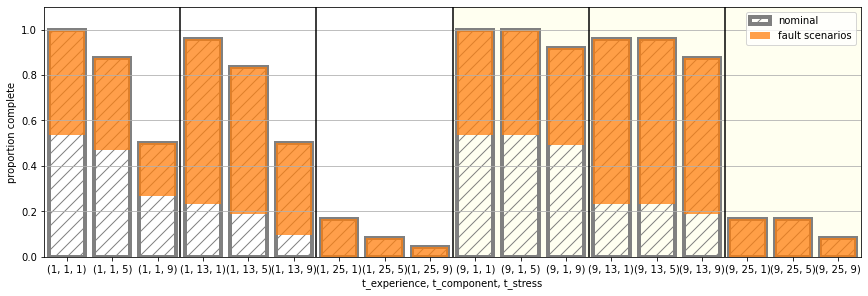

In [88]:
fig = rd.plot.resilience_factor_comparison(res_joint, stack=True, maxy=1.1, xlabel='t_experience, t_component, t_stress', figsize=(12,4), title="", stat="proportion complete") 

In [89]:
fig.savefig("joint_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)